# HSCT survival: XGBoost model +engineered features

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

import configuration as config
import functions.helper as helper_funcs
import functions.plotting as plot_funcs

notebook_num='03.3'
gpu=0

# Data files
datasets_file=f'{config.PROCESSED_DATA}/02.1-dataset_definitions.pkl'
coxph_survival_file=f'{config.PROCESSED_DATA}/02.1-coxPH_survival.pkl'
weibullaft_survival_file=f'{config.PROCESSED_DATA}/02.2-weibullAFT_survival.pkl'
learned_efs_file=f'{config.PROCESSED_DATA}/02.4-learned_efs.pkl'

# Model files
tuned_model_file=f'{config.MODELS_PATH}/{notebook_num}-XGBoost_engineered_features_tuned.pkl'

# Experiment results
hyperparameter_tuning_results=f'{config.DATA_PATH}/results/data/{notebook_num}-hyperparameter_tuning_results.csv'
training_scores_file=f'{config.DATA_PATH}/results/data/{notebook_num}-training_scores.csv'
testing_scores_file=f'{config.DATA_PATH}/results/data/{notebook_num}-testing_scores.csv'

retune_model=True

## 1. Load data

In [2]:
# Read the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

# Load one of the datasets
with open(datasets['Continuous target encoded'], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

# Load Cox Proportional Hazard model features
with open(coxph_survival_file, 'rb') as input_file:
    coxph_features=pickle.load(input_file)

print('\nCox PH features:\n')
for key, value in coxph_features.items():
    print(f' {key}: {type(value)}')

# Load Weibull Accelerated Failure Time model features
with open(weibullaft_survival_file, 'rb') as input_file:
    weibullaft_features=pickle.load(input_file)

print('\nWeibull AFT features:\n')
for key, value in weibullaft_features.items():
    print(f' {key}: {type(value)}')

# Load learned efs features
with open(learned_efs_file, 'rb') as input_file:
    learned_efs_features=pickle.load(input_file)

print('\nLearned EFS features:\n')
for key, value in learned_efs_features.items():
    print(f' {key}: {type(value)}')

Data dictionary contains:

 Training features: <class 'pandas.core.frame.DataFrame'>
 Training labels: <class 'pandas.core.frame.DataFrame'>
 Training IDs: <class 'list'>
 Training race group: <class 'list'>
 Testing features: <class 'pandas.core.frame.DataFrame'>
 Testing labels: <class 'pandas.core.frame.DataFrame'>
 Testing IDs: <class 'list'>
 Testing race group: <class 'list'>

Cox PH features:

 Training survival: <class 'list'>
 Training partial hazard: <class 'list'>
 Testing survival: <class 'list'>
 Testing partial hazard: <class 'list'>

Weibull AFT features:

 Training survival: <class 'list'>
 Training expectation: <class 'list'>
 Testing survival: <class 'list'>
 Testing expectation: <class 'list'>

Learned EFS features:

 Training efs probability: <class 'numpy.ndarray'>
 Testing efs probability: <class 'numpy.ndarray'>


## 2. Data preparation

### 2.1. Add survival model features

In [3]:
training_features_df=data_dict['Training features']
training_features_df['CoxPH survival']=coxph_features['Training survival']
training_features_df['CoxPH partial hazard']=coxph_features['Training partial hazard']
training_features_df['WeibullAFT survival']=weibullaft_features['Training survival']
training_features_df['WeibullAFT expectation']=weibullaft_features['Training expectation']

testing_features_df=data_dict['Testing features']
testing_features_df['CoxPH survival']=coxph_features['Testing survival']
testing_features_df['CoxPH partial hazard']=coxph_features['Testing partial hazard']
testing_features_df['WeibullAFT survival']=weibullaft_features['Testing survival']
testing_features_df['WeibullAFT expectation']=weibullaft_features['Testing expectation']

training_features_df.head().transpose()

,0,1,2,3,4
psych_disturb,24.255348,24.255348,24.255348,24.255348,18.332289
diabetes,19.247242,24.469782,24.469782,19.247242,19.640090
tbi_status,22.744724,22.744724,22.744724,23.980891,23.980891
arrhythmia,23.949337,23.949337,23.949337,23.949337,18.188693
graft_type,21.000471,21.000471,28.989121,21.000471,28.989121
...,...,...,...,...,...
age_at_hct,45.076000,40.851000,34.568000,52.419000,55.890000
CoxPH survival,0.243637,0.363744,0.516802,0.194666,0.388247
CoxPH partial hazard,1.880348,1.346671,0.878995,2.179151,1.259862
WeibullAFT survival,0.063881,0.099494,0.268041,0.013788,0.146418


### 2.2. Add learned EFS features

In [4]:
training_features_df['learned_efs']=learned_efs_features['Training efs probability']
testing_features_df['learned_efs']=learned_efs_features['Testing efs probability']

training_features_df.head().transpose()

,0,1,2,3,4
psych_disturb,24.255348,24.255348,24.255348,24.255348,18.332289
diabetes,19.247242,24.469782,24.469782,19.247242,19.640090
tbi_status,22.744724,22.744724,22.744724,23.980891,23.980891
arrhythmia,23.949337,23.949337,23.949337,23.949337,18.188693
graft_type,21.000471,21.000471,28.989121,21.000471,28.989121
...,...,...,...,...,...
CoxPH survival,0.243637,0.363744,0.516802,0.194666,0.388247
CoxPH partial hazard,1.880348,1.346671,0.878995,2.179151,1.259862
WeibullAFT survival,0.063881,0.099494,0.268041,0.013788,0.146418
WeibullAFT expectation,46.464758,59.920349,135.041976,24.464473,78.127198


### 2.3. Load labels, race group and ID

In [5]:
training_labels_df=data_dict['Training labels']
training_labels_df['log_efs_time']=np.log(training_labels_df['efs_time'])
training_labels_df['reciprocal_efs_time']=1/(training_labels_df['efs_time'])
training_labels_df['square_root_efs_time']=training_labels_df['efs_time']**0.5
training_labels_df['polynomial_efs_time']=training_labels_df['efs_time']**2
training_labels_df['power_efs_time']=1.1**training_labels_df['efs_time']
training_race_groups=data_dict['Training race group']
training_ids=data_dict['Training IDs']

testing_labels_df=data_dict['Testing labels']
testing_labels_df['log_efs_time']=np.log(testing_labels_df['efs_time'])
testing_labels_df['reciprocal_efs_time']=1/(testing_labels_df['efs_time'])
testing_labels_df['square_root_efs_time']=testing_labels_df['efs_time']**0.5
testing_labels_df['polynomial_efs_time']=testing_labels_df['efs_time']**2
testing_labels_df['power_efs_time']=1.1**testing_labels_df['efs_time']
testing_race_groups=data_dict['Testing race group']
testing_ids=data_dict['Testing IDs']

## 3. Label transformation testing

Label type: efs_time


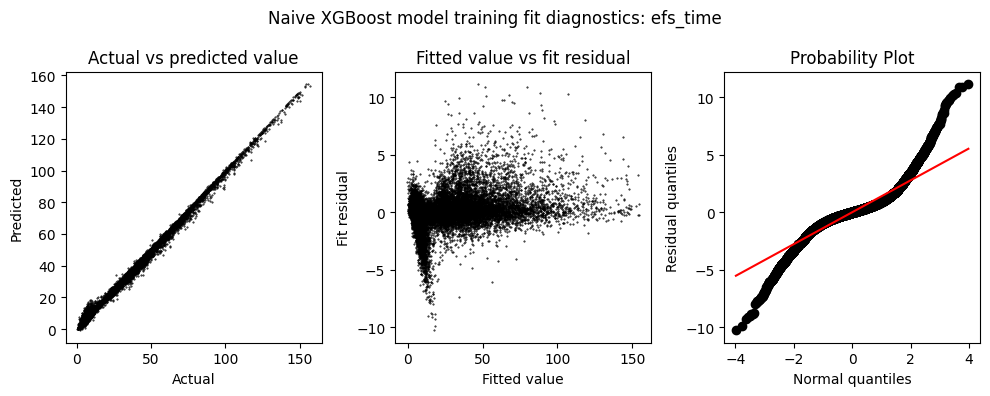

Label type: log_efs_time


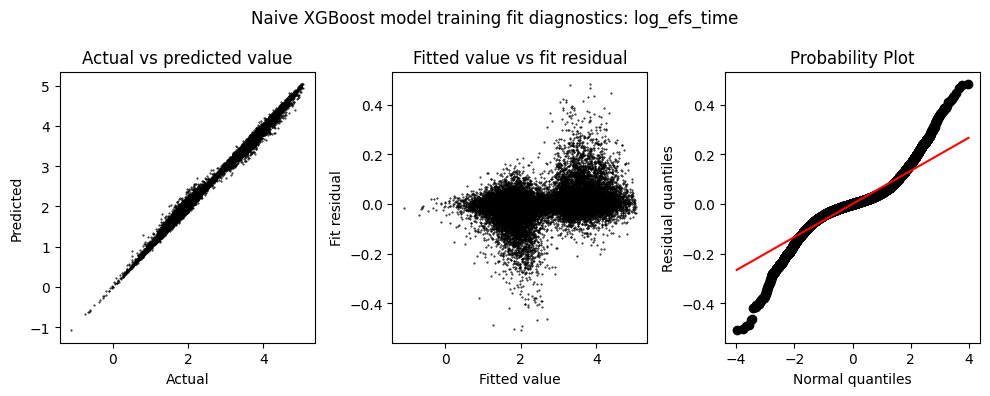

Label type: reciprocal_efs_time


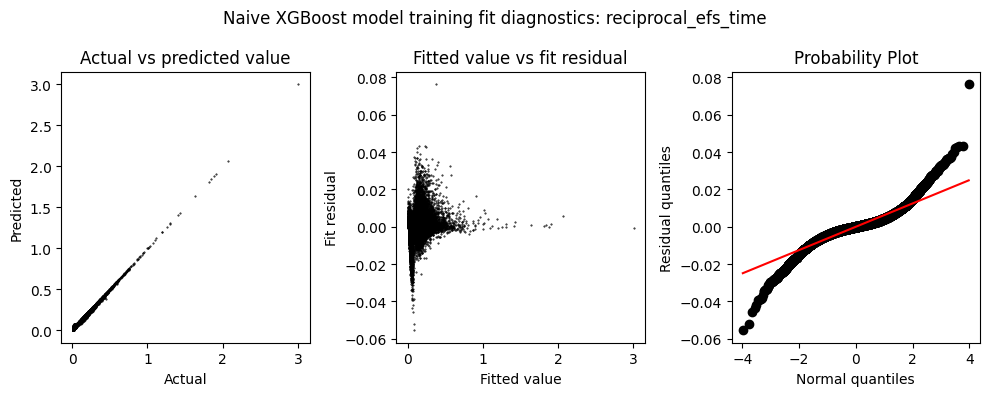

Label type: square_root_efs_time


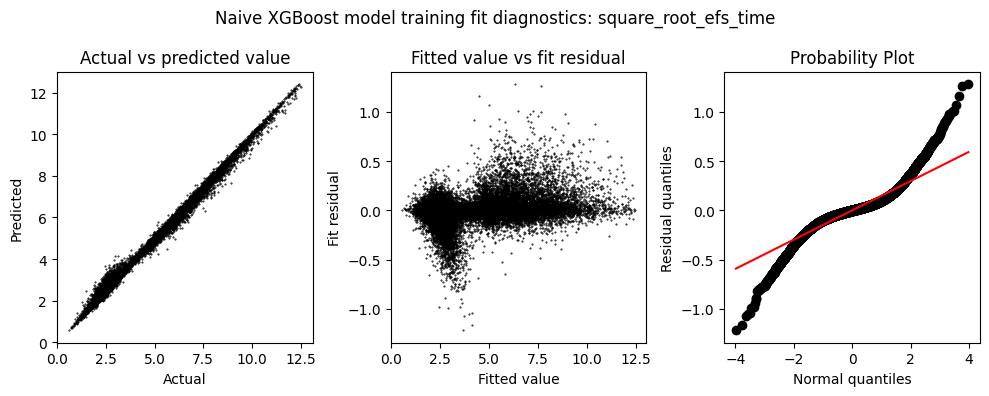

Label type: polynomial_efs_time


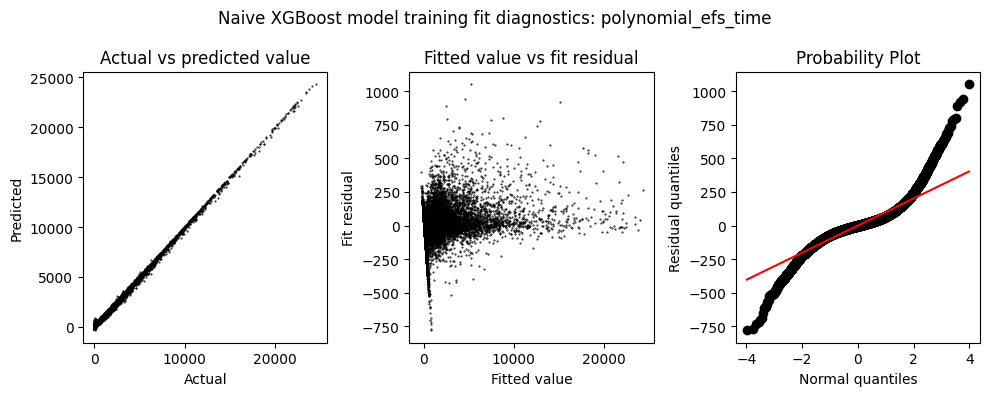

Label type: power_efs_time


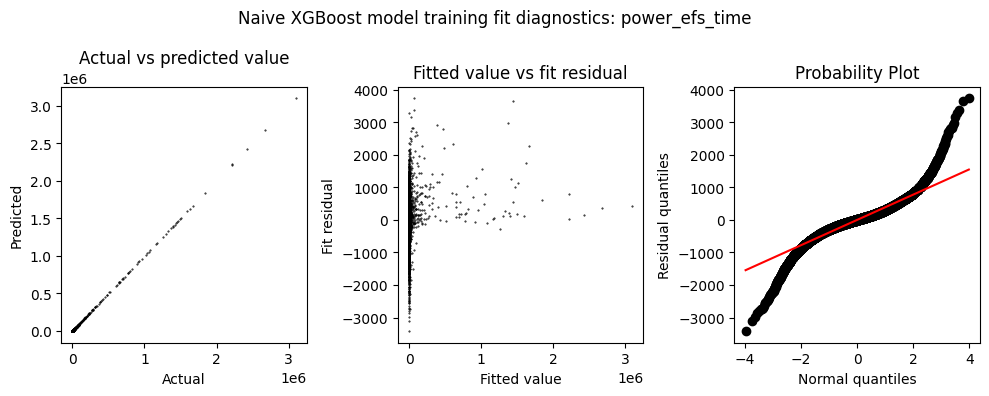

In [6]:
label_types=[
    'efs_time',
    'log_efs_time',
    'reciprocal_efs_time',
    'square_root_efs_time',
    'polynomial_efs_time',
    'power_efs_time'
]

training_score_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

testing_score_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

for label_type in label_types:

    print(f'Label type: {label_type}')

    # XGBoost Model
    xgb_params={
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 315
    }

    if gpu != None:
        xgb_params['gpu_id']=gpu
        xgb_params['tree_method']='gpu_hist'

    # Train on the complete training set
    dtraining=xgb.DMatrix(
        training_features_df, 
        label=training_labels_df[label_type]
    )

    naive_model=xgb.train(
        xgb_params,
        dtraining,
        num_boost_round=1000,
        evals=[(dtraining, 'training')],
        early_stopping_rounds=100,
        verbose_eval=0
    )

    # Make predictions for the training set
    training_predictions=naive_model.predict(dtraining)

    # Make predictions for the testing set
    dtesting=xgb.DMatrix(
        testing_features_df, label=testing_labels_df[label_type]
    )

    testing_predictions=naive_model.predict(dtesting)

    # Make fit diagnostic plots
    plot=plot_funcs.prediction_eval_plot(
        f'Naive XGBoost model training fit diagnostics: {label_type}',
        training_predictions,
        training_labels_df[label_type]
    )

    # Save the plot
    plot.savefig(
        f'{config.DATA_PATH}/results/plots/{notebook_num}-fit_diagnostics_engineered_features_naive_xgb_model_{label_type}.jpg',
        dpi=300
    )

    plot.show()

    if label_type=='reciprocal_efs_time':
        training_predictions=-training_predictions
        testing_predictions=-testing_predictions

    # Score the training set predictions for RMSE, C-index and stratified C-index
    training_score_results=helper_funcs.score_predictions(
        f'Naive: {label_type}',
        training_predictions,
        training_labels_df['efs_time'].values,
        training_labels_df['efs'].values,
        training_race_groups,
        training_ids,
        results=training_score_results
    )

    # Score the testing set predictions for RMSE, C-index and stratified C-index
    testing_score_results=helper_funcs.score_predictions(
        f'Naive: {label_type}',
        testing_predictions,
        testing_labels_df['efs_time'].values,
        testing_labels_df['efs'].values,
        testing_race_groups,
        testing_ids,
        results=testing_score_results
    )

## 4. Hyperparameter tuning

In [7]:
%%time

# Manually choose best label transformation based on above plots
label_type='log_efs_time'

# Train or load model as desired
if retune_model == True:

    # Define the hyperparameter search space
    search_space={
        'objective': ['reg:squarederror'],
        'eval_metric': ['rmse'],
        'seed': [315],
        'learning_rate': [0.005,0.01],
        'max_depth': [4,6,8,10],
        'gamma': [0.01,0.02,0.04,0.06],
        'subsample': [0.3,0.4,0.5,0.6]
    }

    if gpu != None:
        search_space['gpu_id']=[gpu]
        search_space['tree_method']=['gpu_hist']

    results_df=helper_funcs.xgb_hyperparameter_search(
        search_space,
        training_features_df,
        training_labels_df[label_type]
    )

    # Save the hyperparameter tuning results
    results_df.to_csv(hyperparameter_tuning_results)

    winning_hyperparameters=dict(results_df.iloc[-1]['Hyperparameters'])
    
    for parameter, value in winning_hyperparameters.items():
        print(f' {parameter}: {value}')

    # Train classifier with best hyperparameters on complete training set
    dtraining=xgb.DMatrix(training_features_df, label=training_labels_df[label_type])
    dtesting=xgb.DMatrix(testing_features_df, label=testing_labels_df[label_type])

    tree_model=xgb.train(
        winning_hyperparameters,
        dtraining,
        num_boost_round=2000,
        evals=[(dtraining, 'training')],
        early_stopping_rounds=100,
        verbose_eval=0
    )

    # Make training predictions
    training_predictions=tree_model.predict(dtraining)

    # Make testing predictions
    testing_predictions=tree_model.predict(dtesting)

print()

 objective: reg:squarederror
 eval_metric: rmse
 seed: 315
 learning_rate: 0.01
 max_depth: 8
 gamma: 0.01
 subsample: 0.4
 gpu_id: 0
 tree_method: gpu_hist

CPU times: user 2h 8min 52s, sys: 31.3 s, total: 2h 9min 23s
Wall time: 2h 1min 47s


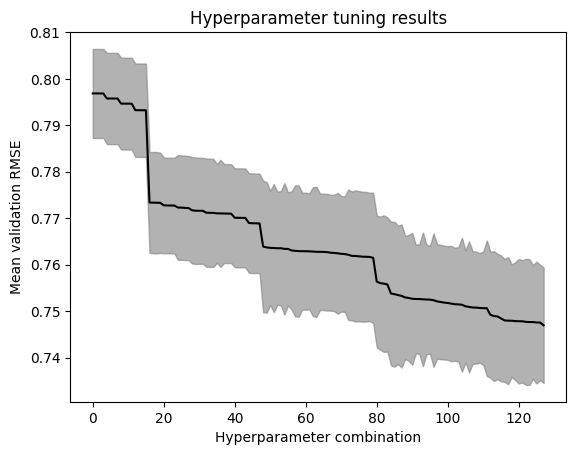

In [8]:
plt.title('Hyperparameter tuning results')
plt.plot(results_df.index, results_df['Metric mean'], color='black')

plt.fill_between(
    results_df.index,
    results_df['Metric mean'] - results_df['Metric standard deviation'],
    results_df['Metric mean'] + results_df['Metric standard deviation'],
    color='gray',
    alpha=0.6
)

plt.xlabel('Hyperparameter combination')
plt.ylabel('Mean validation RMSE')
plt.show()

## 5. Evaluate tuned model

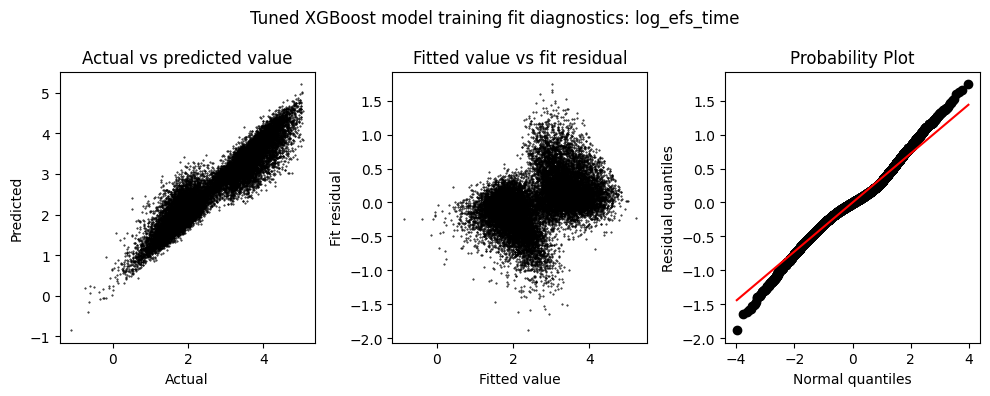

In [9]:
# Make diagnostic plots for the training set
plot=plot_funcs.prediction_eval_plot(
    f'Tuned XGBoost model training fit diagnostics: {label_type}',
    training_predictions,
    training_labels_df[label_type]
)

# Save the plot
plot.savefig(
    f'{config.DATA_PATH}/results/plots/{notebook_num}-fit_diagnostics_tuned_engineered_features_xgb_model_{label_type}.jpg',
    dpi=300
)

plot.show()

# Score the training set predictions for RMSE, C-index and stratified C-index
training_score_results=helper_funcs.score_predictions(
    f'Tuned: {label_type}',
    training_predictions,
    training_labels_df[label_type].values,
    training_labels_df['efs'].values,
    training_race_groups,
    training_ids,
    results=training_score_results,
)

# Score the test set predictions for RMSE, C-index and stratified C-index
testing_score_results=helper_funcs.score_predictions(
    f'Tuned: {label_type}',
    testing_predictions,
    testing_labels_df[label_type].values,
    testing_labels_df['efs'].values,
    testing_race_groups,
    testing_ids,
    results=testing_score_results,
)

## 6. Model comparison

### 6.1. Training set performance

In [10]:
training_score_results_df=pd.DataFrame.from_dict(training_score_results)
training_score_results_df.to_csv(training_scores_file, index=False)
training_score_results_df.head(len(training_score_results_df))

,Model,RMSE,C-index,Stratified C-index
0,Naive: efs_time,1.466164,0.948344,0.936648
1,Naive: log_efs_time,31.687486,0.981990,0.977376
2,Naive: reciprocal_efs_time,34.147748,0.988867,0.985956
3,Naive: square_root_efs_time,29.666481,0.969304,0.961776
4,Naive: polynomial_efs_time,2616.908996,0.868684,0.850279
5,Naive: power_efs_time,67009.937080,0.579012,0.568392
6,Tuned: log_efs_time,0.365194,0.915314,0.901856


### 6.2. Testing set performance

In [11]:
testing_score_results_df=pd.DataFrame.from_dict(testing_score_results)
testing_score_results_df.to_csv(testing_scores_file, index=False)
testing_score_results_df.head(len(testing_score_results_df))

,Model,RMSE,C-index,Stratified C-index
0,Naive: efs_time,24.654762,0.599020,0.592280
1,Naive: log_efs_time,31.774944,0.628114,0.615503
2,Naive: reciprocal_efs_time,33.746600,0.633349,0.622232
3,Naive: square_root_efs_time,30.517807,0.614024,0.602618
4,Naive: polynomial_efs_time,1985.277554,0.574296,0.561435
5,Naive: power_efs_time,42879.009962,0.506853,0.495831
6,Tuned: log_efs_time,1.008902,0.643990,0.631393
